# CNN_Plant_Seedling_Classification


此範例會使用模組化的軟體設計方法，它將一個大型的程式或專案拆分成更小、更容易管理的模塊或組件。每個模塊執行特定的功能或處理特定的任務，並且可以獨立開發、測試和維護。這樣的設計有助於提高程式碼的可讀性、可重用性和可維護性，並且讓不同團隊的開發者能夠協作更輕鬆。在PyTorch中，模組化通常表現為創建獨立的模型、函數和類別，每個模塊負責特定的任務，並且可以輕鬆組合在一起以構建更大的深度學習模型。

本次課程將會把pytorch訓練流程分成以下幾個模組來教學:
1. `Dataset`
2. `Dataloader`
3. `Model`
4. `Train` Function
5. `Valid` Function
6. `Plot Curve` Function
7. `Predict` Function
8. `Main` Function
9. `Addition` Customize model

## Download Datasets

此範例使用kaggle上的[Plant Seedlings Classification](https://www.kaggle.com/c/plant-seedlings-classification)資料集，請先至網站中下載`plant-seedlings-classification.zip`，透過`google.colab`套件，我們可以讓 Colab 上的程式直接讀取自己的雲端硬碟。


執行下面的code之前，請先確保自己的google drive中已經有`plant-seedlings-classification.zip`檔案，並確保檔案位置正確。

掛載自己的google drive後，雲端硬碟的根目錄為: `/content/gdrive/MyDrive/`



In [1]:
import os
import zipfile

data_dir = r'D:\桌面\plant\plant-seedlings-classification'

# if not os.path.exists(data_dir):
# zip_dir = r'C:/Users/User/Downloads//plant-seedlings-classification.zip' # your zip file's dir

# with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
#     zip_ref.extractall(data_dir)


## Import Package

In [2]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from torchvision import models
from torchvision.utils import make_grid
from torchvision import transforms as tsfm
from torchvision.datasets import ImageFolder

import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path
from IPython import display

# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.backends.cudnn.deterministic = True

## Config
Config of Hyperparameter

In [3]:
# Set Hyperparameters
batch_size = 8
epochs = 50
learning_rate = 0.001
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

## 1. Custom Pytorch Dataset


A `Dataset` in Pytorch should have three methods:

1. `__init__`: Read data & preprocess
2. `__len__`: return a integer indicating the size of the dataset
3. `__getitem__`: given an index `idx`, return the `idx`-th sample

In our case, the download data is structured as:
```
├── train
│   ├── Black-grass (Class name)
│   │   ├── 0050f38b3.png
│   │   ├── 0183fdf68.png
│   │   ├── 0260cffa8.png
│   │   ├── ...
│   └── Charlock
│   │   ├── 022179d65.png
│   │   ├── 02c95e601.png
│   │   ├── 04098447d.png
│   │   ├── ...
│   └── ...
├── test
│   ├── 0021e90e4.png
│   ├── 003d61042.png
│   ├── 007b3da8b.png
│   ├── ...
```

We can simply find all the pngs and load them into memory when needed. In common practice, dataset will receive one or more `torchvision.transforms` which transform the png (loaded as `PIL.Image`) into pytorch tensor.

`Dataloader` batchify the samples in dataset, i.e. builds mini-batch from the data return by dataset's `__getitem__` . We then iterate the `Dataloader` for training.

Usually `Dataloader` is finite and will run of mini-batches when we have seen all samples in `Dataset` once. However, to write our code easily, we can create an infinite `Sampler` that can guide the batchification process in `Dataloader` and make `Dataloader` supply mini-batches infinitely.

In [4]:
class Train_data(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = ImageFolder(root=root_dir, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        return img, label

class Pred_data(Dataset):
    def __init__(self, root_dir, transform=None):
        self.img_paths = list(Path(root_dir).glob('*.png'))
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx])
        img = self.transform(img)
        img = img.unsqueeze(0)
        return img

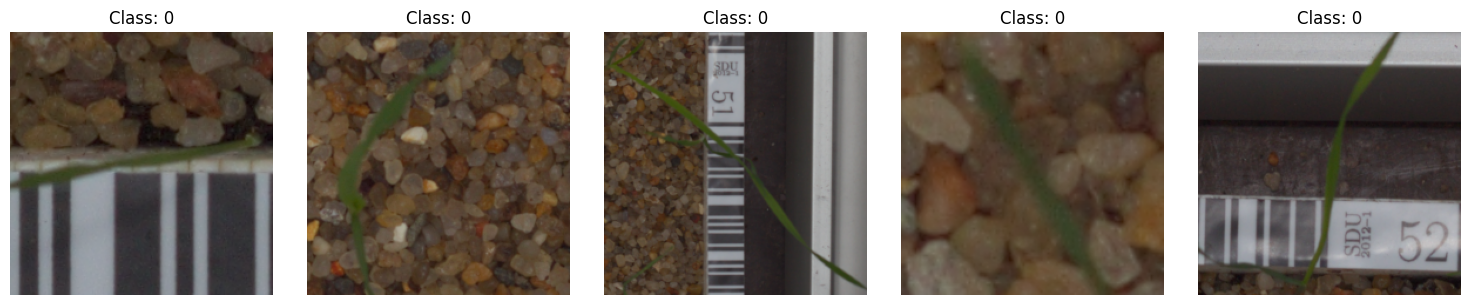

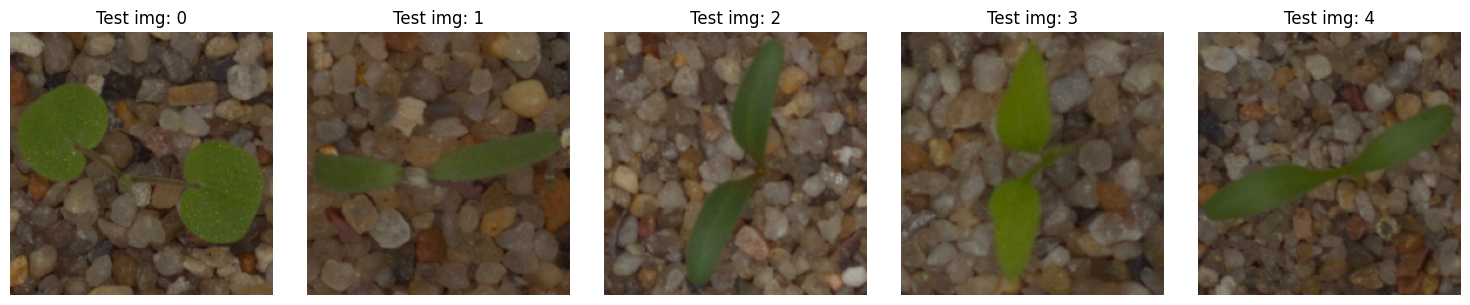

In [5]:
# visualize dataset item for debug
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
transform = tsfm.Compose([
    tsfm.Resize((224, 224)),
    tsfm.ToTensor(),
])

whole_set = Train_data(
    root_dir=train_dir,
    transform=transform
)

test_set = Pred_data(
    root_dir=test_dir,
    transform=transform
)

num_images_to_display = 5
fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 3))

for i, (img, label) in enumerate(whole_set):
    axs[i].imshow(img.permute(1, 2, 0))
    axs[i].set_title(f'Class: {label}')
    axs[i].axis('off')

    num_images_to_display -= 1
    if num_images_to_display == 0:
        break

plt.tight_layout()
plt.show()

num_images_to_display = 5
fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i, img in enumerate(test_set):
    axs[i].imshow(img[0].permute(1, 2, 0))
    axs[i].set_title(f'Test img: {i}')
    axs[i].axis('off')

    num_images_to_display -= 1
    if num_images_to_display == 0:
        break

plt.tight_layout()
plt.show()

## 2. Split train, valid set and Create Dataloader:


In [6]:
train_set, valid_set = random_split(whole_set, [0.8, 0.2])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

## 3. Create Model

A `nn.Module` in Pytorch should have two methods:

1. `__init__`: Initialize your model & define layers
2. `forward`: Compute output of your Model



In [9]:
class resnet_50(nn.Module):
    def __init__(self, num_classes = 12):
        super(resnet_50, self).__init__()
        # pytorch built-in models
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # set model layers trainable
        for param in self.resnet50.parameters():
            param.requires_grad = True

        # redifine/customize last classification layer
        self.resnet50.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.resnet50(x)
        return x

In [10]:
# test model for debug

model = resnet_50(num_classes=12).cuda()
# print(model)
x = torch.rand(1, 3, 224, 224).cuda()
y = model(x)
print(x)
print(y)

tensor([[[[0.6671, 0.7646, 0.2732,  ..., 0.2299, 0.8501, 0.7446],
          [0.3145, 0.1770, 0.4947,  ..., 0.2657, 0.5151, 0.2777],
          [0.9626, 0.3276, 0.1024,  ..., 0.8075, 0.6732, 0.5020],
          ...,
          [0.1053, 0.0563, 0.9618,  ..., 0.0177, 0.8644, 0.9249],
          [0.2369, 0.6065, 0.7551,  ..., 0.8097, 0.0856, 0.5755],
          [0.6274, 0.9982, 0.7637,  ..., 0.2613, 0.3500, 0.0402]],

         [[0.5232, 0.1650, 0.3030,  ..., 0.7249, 0.3848, 0.7339],
          [0.5719, 0.4828, 0.7574,  ..., 0.5348, 0.9477, 0.0841],
          [0.2502, 0.2524, 0.9801,  ..., 0.1184, 0.5851, 0.6820],
          ...,
          [0.9749, 0.6790, 0.7742,  ..., 0.9642, 0.1267, 0.7451],
          [0.0856, 0.5820, 0.4309,  ..., 0.6179, 0.5303, 0.8151],
          [0.7269, 0.7204, 0.1821,  ..., 0.2500, 0.2649, 0.3273]],

         [[0.0077, 0.6897, 0.1437,  ..., 0.5420, 0.3801, 0.0750],
          [0.3946, 0.1692, 0.3127,  ..., 0.4402, 0.9574, 0.0358],
          [0.8982, 0.4166, 0.9354,  ..., 0

## 4. Define Train Function(for one epoch):


In [11]:
def train(model, criterion, optimizer, train_loader, epoch, total_epochs, batch_size):
    model.train()
    train_loss, train_acc = [], []

    tqdm_iter = tqdm(train_loader, desc="Epoch: {}/{} ({}%) | Training loss: NaN".format(
    epoch, total_epochs, int(epoch/total_epochs * 100)), leave=False)
    epoch_loss, epoch_acc = 0.0, 0.0
    for batch_idx, (data, label) in enumerate(tqdm_iter):
        data, target = data.cuda(), label.cuda()
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == target).float().mean().item()
        epoch_loss += loss.item()
        epoch_acc += acc

        tqdm_iter.set_description("Epoch: {}/{} ({}%) | Training loss: {:.6f} | Training Acc: {:.6f}".format(
        epoch + 1, total_epochs, int((epoch+1)/total_epochs * 100), round(loss.item(), 6), round(acc, 6)))

    return epoch_loss / len(train_loader), epoch_acc / len(train_loader)

In [12]:
# debug "train" function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

loss, acc = train(
    model,
    criterion,
    optimizer,
    train_loader,
    epoch=1,
    total_epochs=1,
    batch_size=batch_size
)

print(loss, acc)

Epoch: 1/1 (100%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

2.0538473976285836 0.3018421052631579


## 5. Define Valid Function(for one epoch):


In [13]:
def valid(model, criterion, valid_loader, epoch, total_epochs, batch_size):
    model.eval()

    tqdm_iter = tqdm(valid_loader, desc="Epoch: {}/{} ({}%) | Valid loss: NaN".format(
    epoch, total_epochs, int(epoch/total_epochs * 100)), leave=False)
    epoch_loss, epoch_acc = 0.0, 0.0
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(tqdm_iter):
            data, target = data.cuda(), label.cuda()
            output = model(data)
            loss = criterion(output, target)
            acc = (output.argmax(dim=1) == target).float().mean().item()
            epoch_loss += loss.item()
            epoch_acc += acc

            tqdm_iter.set_description("Epoch: {}/{} ({}%) | Valid loss: {:.6f} | Valid Acc: {:.6f}".format(
            epoch + 1, total_epochs, int((epoch+1)/total_epochs * 100), round(loss.item(), 6), round(acc, 6)))

    return epoch_loss / len(valid_loader), epoch_acc / len(valid_loader)

In [14]:
# debug "valid" function
criterion = nn.CrossEntropyLoss()
loss, acc = valid(
    model,
    criterion,
    valid_loader,
    epoch=1,
    total_epochs=1,
    batch_size=batch_size
)

print(loss, acc)

Epoch: 1/1 (100%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

1.611539848712312 0.3907563025210084


## 6. Plot Learning Curve Function:

In [15]:
def Plot(title, ylabel, epochs, train_loss, valid_loss):
    plt.figure()
    plt.title(title)
    plt.xlabel('epochs')
    plt.ylabel(ylabel)
    plt.plot(epochs, train_loss)
    plt.plot(epochs, valid_loss)
    plt.legend(['train', 'valid'], loc='upper left')

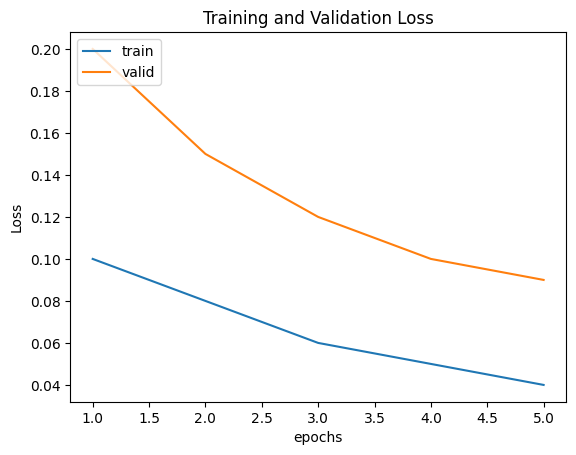

In [16]:
# debug "Plot" function
debug_epochs = [1, 2, 3, 4, 5]
debug_train_loss = [0.1, 0.08, 0.06, 0.05, 0.04]
debug_valid_loss = [0.2, 0.15, 0.12, 0.1, 0.09]

Plot("Training and Validation Loss", 'Loss', debug_epochs, debug_train_loss, debug_valid_loss)

plt.show()

## 7. Predict Function:

In [17]:
def predict(loader, model):
    model.eval()
    preds = []
    for data in tqdm(loader):
        pred = model(data.cuda())
        cls = torch.argmax(pred, dim=1)
        preds.append(cls)

    return preds

In [18]:
# Visualize Predict result
def view_pred_result(preds, num_images_to_display=5):
    labels = ['Black-grass', 'Charlock' , 'Cleavers' , 'Common Chickweed' , 'Common wheat' , 'Fat Hen' , 'Loose Silky-bent' , 'Maize' , 'Scentless Mayweed' , 'Shepherds Purse', 'Small-flowered Cranesbill' , 'Sugar beet']
    fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 3))
    for i, img in enumerate(test_set):
        axs[i].imshow(img[0].permute(1, 2, 0))
        axs[i].set_title(labels[preds[i].item()])
        axs[i].axis('off')

        num_images_to_display -= 1
        if num_images_to_display == 0:
            break

    plt.tight_layout()
    plt.show()

  0%|          | 0/794 [00:00<?, ?it/s]

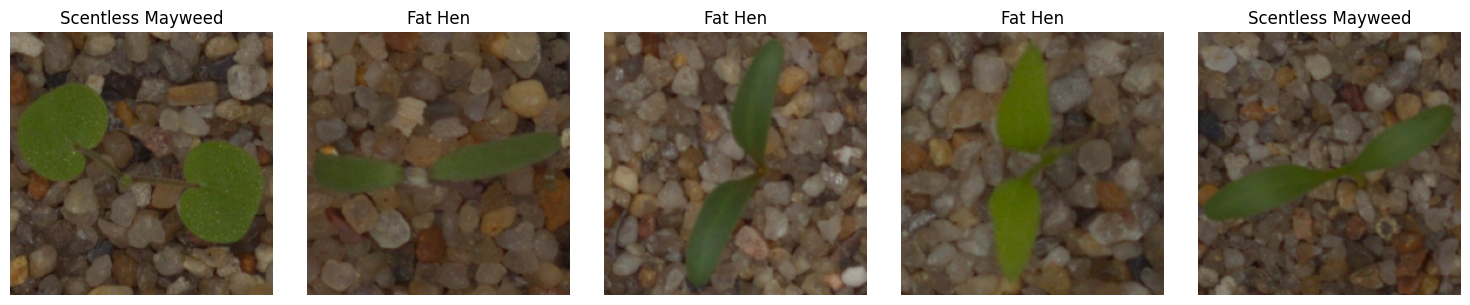

In [19]:
# debug "Predict" function & "View_Predict_result" function
test_dir = os.path.join(data_dir, 'test')
transform = tsfm.Compose([
    tsfm.Resize((224, 224)),
    tsfm.ToTensor(),
])
test_set = Pred_data(
    root_dir=test_dir,
    transform=transform
)
model = resnet_50(num_classes=12).cuda()

preds = predict(test_set, model)
view_pred_result(preds)

## 8. Main Function(training pipeline):
1. `Set Hyperparameters`: `batct_size`, `learning rate`, `epochs`...
2. `Initial`: initial `dataset`, `dataloader`, `model`
3. `Train`: Do train
4. `Valid`: Do valid
5. repeat `3.`  `4.` epochs times
6. `Plot curve`: Plot learning curve to observe the learning progress
7. `Predict`: Use the trained model to predict the results of the test set

50


Epoch: 0/50 (0%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.7878899674455658, Avg train acc: 0.7483368350678131


Epoch: 0/50 (0%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.8342675626277923, Avg valid acc: 0.7510416666666667


Epoch: 1/50 (2%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.3123919610403666, Avg train acc: 0.8932072830801251


Epoch: 1/50 (2%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.39479837914307914, Avg valid acc: 0.864678031206131


Epoch: 2/50 (4%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.20771296093819522, Avg train acc: 0.9261204485131913


Epoch: 2/50 (4%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.37595895131429036, Avg valid acc: 0.8589962124824524


Epoch: 3/50 (6%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.15673162814761912, Avg train acc: 0.9454656864414696


Epoch: 3/50 (6%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.45085247109333676, Avg valid acc: 0.8439393957455953


Epoch: 4/50 (8%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.15832694021969282, Avg train acc: 0.9506302521008403


Epoch: 4/50 (8%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.25873592123389244, Avg valid acc: 0.9225378791491191


Epoch: 5/50 (10%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.10517256381772772, Avg train acc: 0.9662990199417627


Epoch: 5/50 (10%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.2189139811632534, Avg valid acc: 0.9298295458157857


Epoch: 6/50 (12%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.07948385076714727, Avg train acc: 0.9742647058823529


Epoch: 6/50 (12%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.3292490693740547, Avg valid acc: 0.9193181832631429


Epoch: 7/50 (14%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.07970005325472154, Avg train acc: 0.9716386554621849


Epoch: 7/50 (14%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.2994826234566669, Avg valid acc: 0.9211174249649048


Epoch: 8/50 (16%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.07457001894925713, Avg train acc: 0.9796918770846199


Epoch: 8/50 (16%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.25176116766718526, Avg valid acc: 0.9401515165964762


Epoch: 9/50 (18%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.05245889464741526, Avg train acc: 0.9821428571428571


Epoch: 9/50 (18%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.31419649347662926, Avg valid acc: 0.927178031206131


Epoch: 10/50 (20%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.09474172367823913, Avg train acc: 0.9708508403361344


Epoch: 10/50 (20%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.21101428642868997, Avg valid acc: 0.9359848499298096


Epoch: 11/50 (22%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.0751870006005898, Avg train acc: 0.9745273109243697


Epoch: 11/50 (22%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.3183778857191404, Avg valid acc: 0.9141098499298096


Epoch: 12/50 (24%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.06679229286182359, Avg train acc: 0.9789915966386554


Epoch: 12/50 (24%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.22281357555960615, Avg valid acc: 0.952178031206131


Epoch: 13/50 (26%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.06096853016867858, Avg train acc: 0.9813550420168067


Epoch: 13/50 (26%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.20423639918056627, Avg valid acc: 0.9505681832631429


Epoch: 14/50 (28%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.05709331378902254, Avg train acc: 0.9838935577568888


Epoch: 14/50 (28%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.4042478067179521, Avg valid acc: 0.8741477290789287


Epoch: 15/50 (30%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.040962950724662286, Avg train acc: 0.9860819327731093


Epoch: 15/50 (30%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.18953538940598566, Avg valid acc: 0.9474431832631429


Epoch: 16/50 (32%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.015339285811994365, Avg train acc: 0.9950105042016807


Epoch: 16/50 (32%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.1682000319318225, Avg valid acc: 0.9578598499298095


Epoch: 17/50 (34%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.027308219779887385, Avg train acc: 0.990546218487395


Epoch: 17/50 (34%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.21685655005276203, Avg valid acc: 0.9464015165964762


Epoch: 18/50 (36%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.027546253145580422, Avg train acc: 0.9921218487394958


Epoch: 18/50 (36%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.3124847502758106, Avg valid acc: 0.910037879149119


Epoch: 19/50 (38%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.0230364004322944, Avg train acc: 0.9936974789915967


Epoch: 19/50 (38%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.23501092748095592, Avg valid acc: 0.9423295458157858


Epoch: 20/50 (40%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.0715450833888114, Avg train acc: 0.9763655462184874


Epoch: 20/50 (40%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.34868585256238777, Avg valid acc: 0.9121212124824524


Epoch: 21/50 (42%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.04655149922571184, Avg train acc: 0.9855567226890757


Epoch: 21/50 (42%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.310912678980579, Avg valid acc: 0.9241477290789286


Epoch: 22/50 (44%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.030903741939897266, Avg train acc: 0.9915966386554622


Epoch: 22/50 (44%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.2226204730415096, Avg valid acc: 0.9557765165964762


Epoch: 23/50 (46%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.03120474005038527, Avg train acc: 0.9894957983193278


Epoch: 23/50 (46%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.23153107867886621, Avg valid acc: 0.939678031206131


Epoch: 24/50 (48%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.03413144893603822, Avg train acc: 0.9881827731092437


Epoch: 24/50 (48%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.351774408792456, Avg valid acc: 0.9235795458157857


Epoch: 25/50 (50%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.05333436435485208, Avg train acc: 0.9808298319327731


Epoch: 25/50 (50%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.37191874186197915, Avg valid acc: 0.895928031206131


Epoch: 26/50 (52%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.05132699379122213, Avg train acc: 0.9839810924369747


Epoch: 26/50 (52%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.29283214298387367, Avg valid acc: 0.936553031206131


Epoch: 27/50 (54%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.020274104197810897, Avg train acc: 0.9934348739495799


Epoch: 27/50 (54%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.20855074524879455, Avg valid acc: 0.9480113645394643


Epoch: 28/50 (56%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.008170347878630684, Avg train acc: 0.9965861344537815


Epoch: 28/50 (56%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.26238987762480975, Avg valid acc: 0.9491477290789286


Epoch: 29/50 (57%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.031192791424030114, Avg train acc: 0.9910714285714286


Epoch: 29/50 (57%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.5752951045831044, Avg valid acc: 0.8329545458157858


Epoch: 30/50 (60%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.053374304919295255, Avg train acc: 0.9816176470588235


Epoch: 30/50 (60%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.34181070836881794, Avg valid acc: 0.9208333333333333


Epoch: 31/50 (62%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.044077851735456544, Avg train acc: 0.9863445378151261


Epoch: 31/50 (62%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.23716602558270097, Avg valid acc: 0.9349431832631429


Epoch: 32/50 (64%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.013497381580236834, Avg train acc: 0.9957983193277311


Epoch: 32/50 (64%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.20420806038503844, Avg valid acc: 0.9572916666666667


Epoch: 33/50 (66%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.008969670778716143, Avg train acc: 0.9978991596638656


Epoch: 33/50 (66%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.20191669190535322, Avg valid acc: 0.9526515165964763


Epoch: 34/50 (68%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.0017908060308094596, Avg train acc: 0.9997373949579832


Epoch: 34/50 (68%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.19820529986027396, Avg valid acc: 0.9557765165964762


Epoch: 35/50 (70%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.0005324687779480088, Avg train acc: 1.0


Epoch: 35/50 (70%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.18187805580625233, Avg valid acc: 0.9589015165964763


Epoch: 36/50 (72%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.001340594073055109, Avg train acc: 0.9992121848739496


Epoch: 36/50 (72%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.19268815815642787, Avg valid acc: 0.9516098499298096


Epoch: 37/50 (74%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.0014082404706656968, Avg train acc: 0.9997373949579832


Epoch: 37/50 (74%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.17008592739148298, Avg valid acc: 0.9578598499298095


Epoch: 38/50 (76%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.004717711678968961, Avg train acc: 0.998686974789916


Epoch: 38/50 (76%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.2701417090371251, Avg valid acc: 0.9411931832631429


Epoch: 39/50 (78%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.05356735657863153, Avg train acc: 0.9838935577568888


Epoch: 39/50 (78%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.5719847115377585, Avg valid acc: 0.8658143957455953


Epoch: 40/50 (80%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.09098693270807569, Avg train acc: 0.9725140057692007


Epoch: 40/50 (80%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.47866335610548655, Avg valid acc: 0.8433712124824524


Epoch: 41/50 (82%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.05582844274570508, Avg train acc: 0.9850315126050421


Epoch: 41/50 (82%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.22688330464685957, Avg valid acc: 0.9370265165964763


Epoch: 42/50 (84%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.006461475685384602, Avg train acc: 0.9981617647058824


Epoch: 42/50 (84%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.2513689477307101, Avg valid acc: 0.942803031206131


Epoch: 43/50 (86%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.008421980349729503, Avg train acc: 0.9976365546218487


Epoch: 43/50 (86%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.2347970469815967, Avg valid acc: 0.9536931832631429


Epoch: 44/50 (88%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.0037745265647060456, Avg train acc: 0.9989495798319328


Epoch: 44/50 (88%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.22923961381893604, Avg valid acc: 0.9557765165964762


Epoch: 45/50 (90%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.0009151903521709174, Avg train acc: 1.0


Epoch: 45/50 (90%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.21343160360944846, Avg valid acc: 0.9557765165964762


Epoch: 46/50 (92%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.00021431814535703358, Avg train acc: 1.0


Epoch: 46/50 (92%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.22896577719802735, Avg valid acc: 0.9609848499298096


Epoch: 47/50 (94%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 0.0001747745566530391, Avg train acc: 1.0


Epoch: 47/50 (94%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.23344596876268042, Avg valid acc: 0.9589015165964763


Epoch: 48/50 (96%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 9.464489522244793e-05, Avg train acc: 1.0


Epoch: 48/50 (96%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.23988066062399108, Avg valid acc: 0.9557765165964762


Epoch: 49/50 (98%) | Training loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg train Loss: 8.74365864432502e-05, Avg train acc: 1.0


Epoch: 49/50 (98%) | Valid loss: NaN:   0%|          | 0/30 [00:00<?, ?it/s]

Avg valid Loss: 0.23914632841090983, Avg valid acc: 0.9589015165964763


  0%|          | 0/794 [00:00<?, ?it/s]

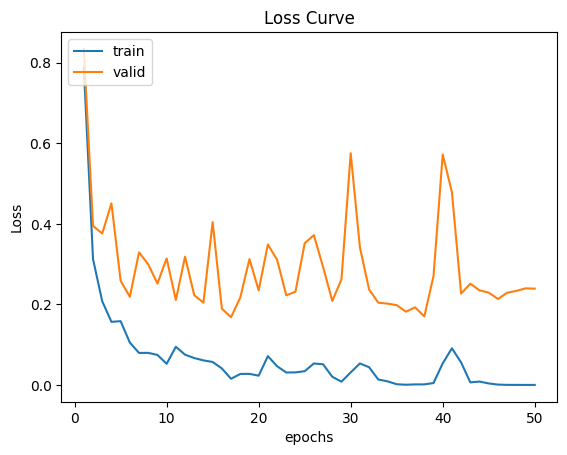

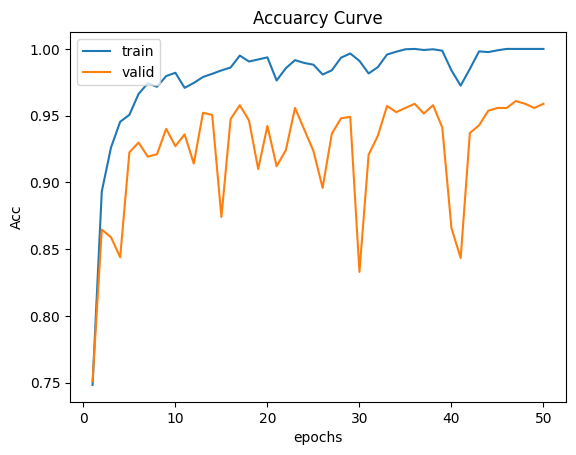

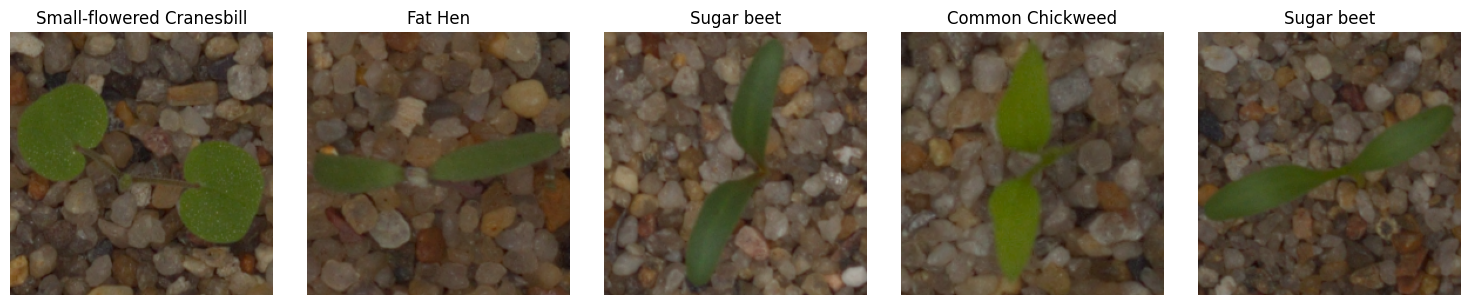

In [18]:
def main():
    # initial transform
    transform = tsfm.Compose([
        tsfm.Resize((224, 224)),
        tsfm.ToTensor(),
    ])

    # initial dataset
    whole_set = Train_data(
        root_dir=train_dir,
        transform=transform
    )

    test_set = Pred_data(
        root_dir=test_dir,
        transform=transform
    )

    # split train valid and initial dataloader
    train_set_size = int(len(whole_set) * 0.8)
    valid_set_size = len(whole_set) - train_set_size
    train_set, valid_set = random_split(whole_set, [train_set_size, valid_set_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size)

    # initial model
    model = resnet_50(num_classes=12).cuda()

    # initial loss_function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # initial plot values
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    epoch_list = []

    # repeat train and valid epochs times
    print(epochs)
    for epoch in range(epochs):
      epoch_list.append(epoch + 1)

      loss, acc = train(
          model,
          criterion,
          optimizer,
          train_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      train_loss.append(loss)
      train_acc.append(acc)
      print(f'Avg train Loss: {loss}, Avg train acc: {acc}')

      loss, acc = valid(
          model,
          criterion,
          valid_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      valid_loss.append(loss)
      valid_acc.append(acc)
      print(f'Avg valid Loss: {loss}, Avg valid acc: {acc}')

    Plot("Loss Curve", 'Loss', epoch_list, train_loss, valid_loss)
    Plot("Accuarcy Curve", 'Acc', epoch_list, train_acc, valid_acc)

    preds = predict(test_set, model)
    view_pred_result(preds)

main()

## 9. Addition: Customize your own model
Create your own deep learning model, by define the inner layers in hand-craft<br>
Example for VGG16 model: https://arxiv.org/abs/1409.1556

In [20]:
class VGG16(nn.Module):
    def __init__(self, num_classes=12):
        super(VGG16, self).__init__()
        # input layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        #  classifier
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU()
        )

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU()
        )

        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [21]:
# Test model to debug
x = torch.rand(1, 3, 224, 224)
model = VGG16(num_classes=12)
y = model(x)
print(y)

tensor([[-0.1931, -0.1623, -0.0033,  0.1125, -0.2772, -0.0048,  0.3244,  0.0162,
          0.0458, -0.3026, -0.2081,  0.3849]], grad_fn=<AddmmBackward0>)


Rerun training for VGG16 model

50


Epoch: 0/50 (0%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 2.842041839298449, Avg train acc: 0.17894736842105263


Epoch: 0/50 (0%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 2.0442008120673045, Avg valid acc: 0.29656862749272034


Epoch: 1/50 (2%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 2.2113801361385144, Avg train acc: 0.22763157894736843


Epoch: 1/50 (2%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 2.161846914211241, Avg valid acc: 0.2724089636271741


Epoch: 2/50 (4%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 2.0875343229896144, Avg train acc: 0.27052631578947367


Epoch: 2/50 (4%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.863026188201263, Avg valid acc: 0.35784313733838186


Epoch: 3/50 (6%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 2.005418112403468, Avg train acc: 0.30289473684210527


Epoch: 3/50 (6%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.7738508176402885, Avg valid acc: 0.37359943985939026


Epoch: 4/50 (8%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.952367283419559, Avg train acc: 0.31684210526315787


Epoch: 4/50 (8%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.8636022185077186, Avg valid acc: 0.3375350140473422


Epoch: 5/50 (10%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.9189657686886035, Avg train acc: 0.3173684210526316


Epoch: 5/50 (10%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.7556369214498697, Avg valid acc: 0.38130252100840334


Epoch: 6/50 (12%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.8847778365486547, Avg train acc: 0.33210526315789474


Epoch: 6/50 (12%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.7551722316180958, Avg valid acc: 0.41001400564398083


Epoch: 7/50 (14%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.8666438388824462, Avg train acc: 0.34


Epoch: 7/50 (14%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.8038612173384978, Avg valid acc: 0.35434173673641783


Epoch: 8/50 (16%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.8461749237462095, Avg train acc: 0.34578947368421054


Epoch: 8/50 (16%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.7387221851268737, Avg valid acc: 0.37009803925742624


Epoch: 9/50 (18%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.8531952614533274, Avg train acc: 0.33710526315789474


Epoch: 9/50 (18%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.6226064327384244, Avg valid acc: 0.41106442581204805


Epoch: 10/50 (20%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.8167275732441952, Avg train acc: 0.36


Epoch: 10/50 (20%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.6134237817355566, Avg valid acc: 0.4544817928005667


Epoch: 11/50 (22%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.7903072493954708, Avg train acc: 0.36447368421052634


Epoch: 11/50 (22%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.620411613408257, Avg valid acc: 0.4394257703498632


Epoch: 12/50 (24%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.7735802300352799, Avg train acc: 0.37605263157894736


Epoch: 12/50 (24%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.5642675271555155, Avg valid acc: 0.49439775918712137


Epoch: 13/50 (26%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.7540098510290447, Avg train acc: 0.39763157894736845


Epoch: 13/50 (26%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.554450485886646, Avg valid acc: 0.5112044818761969


Epoch: 14/50 (28%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.685295107992072, Avg train acc: 0.42026315789473684


Epoch: 14/50 (28%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.5826623439788818, Avg valid acc: 0.47128851548964235


Epoch: 15/50 (30%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.6614046222285221, Avg train acc: 0.4313157894736842


Epoch: 15/50 (30%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.5989768244639164, Avg valid acc: 0.4912464986829197


Epoch: 16/50 (32%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.643859351183239, Avg train acc: 0.4368421052631579


Epoch: 16/50 (32%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.476106938193826, Avg valid acc: 0.5392156863162497


Epoch: 17/50 (34%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.599471209049225, Avg train acc: 0.45105263157894737


Epoch: 17/50 (34%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.399029031521132, Avg valid acc: 0.5794817928005668


Epoch: 18/50 (36%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.56038744794695, Avg train acc: 0.4594736842105263


Epoch: 18/50 (36%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.4874672378812517, Avg valid acc: 0.46603641464930623


Epoch: 19/50 (38%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.534307328650826, Avg train acc: 0.4726315789473684


Epoch: 19/50 (38%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.2951156046210217, Avg valid acc: 0.5700280112879617


Epoch: 20/50 (40%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.5152419397078063, Avg train acc: 0.48105263157894734


Epoch: 20/50 (40%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.457847215548283, Avg valid acc: 0.5290616247333398


Epoch: 21/50 (42%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.5345902488106176, Avg train acc: 0.47657894736842105


Epoch: 21/50 (42%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.3217242515387655, Avg valid acc: 0.580532212968634


Epoch: 22/50 (44%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.480433065389332, Avg train acc: 0.4868421052631579


Epoch: 22/50 (44%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.8280252689073067, Avg valid acc: 0.36869747899159666


Epoch: 23/50 (46%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.4609753155708314, Avg train acc: 0.49605263157894736


Epoch: 23/50 (46%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.2210664633943253, Avg valid acc: 0.6407563025210085


Epoch: 24/50 (48%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.4416448101244475, Avg train acc: 0.503421052631579


Epoch: 24/50 (48%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.3515772709325582, Avg valid acc: 0.5315126050420168


Epoch: 25/50 (50%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.3778708648681641, Avg train acc: 0.5144736842105263


Epoch: 25/50 (50%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.2748355610030038, Avg valid acc: 0.576330532296365


Epoch: 26/50 (52%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.3924380268548664, Avg train acc: 0.5157894736842106


Epoch: 26/50 (52%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.5950916003780204, Avg valid acc: 0.3865546218487395


Epoch: 27/50 (54%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.3034101231474626, Avg train acc: 0.5478947368421052


Epoch: 27/50 (54%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.1421080529689789, Avg valid acc: 0.6120448180106508


Epoch: 28/50 (56%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.3056545928277468, Avg train acc: 0.5534210526315789


Epoch: 28/50 (56%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.1384485839795666, Avg valid acc: 0.6162464986829197


Epoch: 29/50 (57%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.2623877594972912, Avg train acc: 0.5671052631578948


Epoch: 29/50 (57%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.251427527736215, Avg valid acc: 0.6050420168067226


Epoch: 30/50 (60%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.251367214102494, Avg train acc: 0.5726315789473684


Epoch: 30/50 (60%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.0866646446099801, Avg valid acc: 0.6652661066095368


Epoch: 31/50 (62%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.2145101788796877, Avg train acc: 0.5763157894736842


Epoch: 31/50 (62%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.4254686662128992, Avg valid acc: 0.45553221296863394


Epoch: 32/50 (64%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.1586314340014208, Avg train acc: 0.5978947368421053


Epoch: 32/50 (64%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 0.9858863769459123, Avg valid acc: 0.667016806722689


Epoch: 33/50 (66%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.0812123029482992, Avg train acc: 0.6176315789473684


Epoch: 33/50 (66%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.0414593925996989, Avg valid acc: 0.6439075630252101


Epoch: 34/50 (68%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.0711038178519199, Avg train acc: 0.6276315789473684


Epoch: 34/50 (68%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 0.9873825406827846, Avg valid acc: 0.6628151260504201


Epoch: 35/50 (70%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 1.0278924774496179, Avg train acc: 0.6552631578947369


Epoch: 35/50 (70%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 0.9923557165791007, Avg valid acc: 0.6621148461053351


Epoch: 36/50 (72%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 0.9870993548945377, Avg train acc: 0.666578947368421


Epoch: 36/50 (72%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 0.9011632936591861, Avg valid acc: 0.6901260504201681


Epoch: 37/50 (74%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 0.9423985869319815, Avg train acc: 0.6868421052631579


Epoch: 37/50 (74%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 1.1266395321914129, Avg valid acc: 0.5749299721557553


Epoch: 38/50 (76%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 0.8694210781549152, Avg train acc: 0.7073684210526315


Epoch: 38/50 (76%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 0.8464264241086334, Avg valid acc: 0.7058823529411765


Epoch: 39/50 (78%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 0.8279332037662205, Avg train acc: 0.7263157894736842


Epoch: 39/50 (78%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 0.853748904055908, Avg valid acc: 0.7114845940044948


Epoch: 40/50 (80%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 0.7551130603096987, Avg train acc: 0.7463157894736843


Epoch: 40/50 (80%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 0.7833750612345063, Avg valid acc: 0.7377450982061755


Epoch: 41/50 (82%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 0.6583877941044538, Avg train acc: 0.7773684210526316


Epoch: 41/50 (82%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 0.6134717177067485, Avg valid acc: 0.7934173671137384


Epoch: 42/50 (84%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 0.6381610358251553, Avg train acc: 0.7889473684210526


Epoch: 42/50 (84%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 0.7037773482939776, Avg valid acc: 0.7839635856011334


Epoch: 43/50 (86%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 0.5966257940468035, Avg train acc: 0.795


Epoch: 43/50 (86%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 0.5985288504792863, Avg valid acc: 0.7997198881221419


Epoch: 44/50 (88%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 0.5408351642432574, Avg train acc: 0.8210526315789474


Epoch: 44/50 (88%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 0.5981982257941096, Avg valid acc: 0.8252801123787376


Epoch: 45/50 (90%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 0.49856424056385695, Avg train acc: 0.8328947368421052


Epoch: 45/50 (90%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 0.5203022852289576, Avg valid acc: 0.8301820729960915


Epoch: 46/50 (92%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 0.47772606041674553, Avg train acc: 0.8392105263157895


Epoch: 46/50 (92%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 0.47745807151145797, Avg valid acc: 0.8417366948448309


Epoch: 47/50 (94%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 0.410059711162344, Avg train acc: 0.8571052631578947


Epoch: 47/50 (94%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 0.5426044513729691, Avg valid acc: 0.8270308124918898


Epoch: 48/50 (96%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 0.43637156491167844, Avg train acc: 0.8515789473684211


Epoch: 48/50 (96%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 0.46058740255524633, Avg valid acc: 0.8490896360213015


Epoch: 49/50 (98%) | Training loss: NaN:   0%|          | 0/475 [00:00<?, ?it/s]

Avg train Loss: 0.3728231972030143, Avg train acc: 0.8742105263157894


Epoch: 49/50 (98%) | Valid loss: NaN:   0%|          | 0/119 [00:00<?, ?it/s]

Avg valid Loss: 0.5716005158023674, Avg valid acc: 0.8217787116515536


  0%|          | 0/794 [00:00<?, ?it/s]

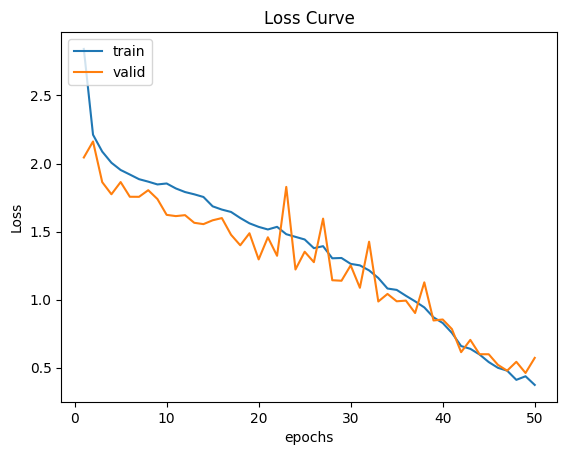

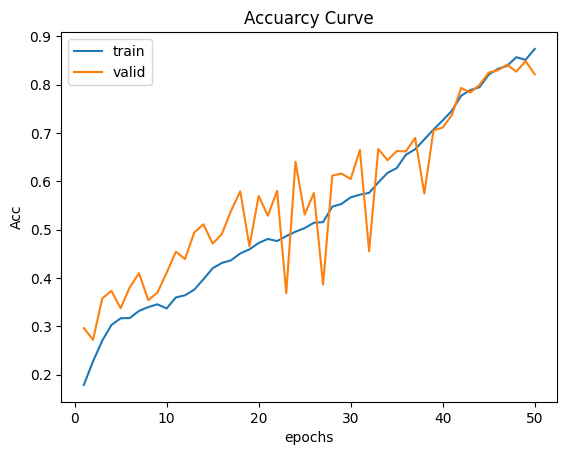

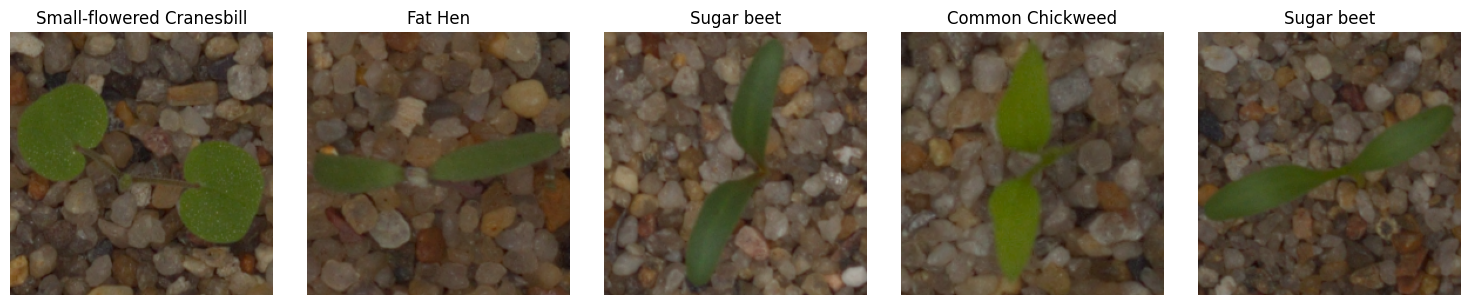

In [22]:
def main():
    # initial transform
    transform = tsfm.Compose([
        tsfm.Resize((224, 224)),
        tsfm.ToTensor(),
    ])

    # initial dataset
    whole_set = Train_data(
        root_dir=train_dir,
        transform=transform
    )

    test_set = Pred_data(
        root_dir=test_dir,
        transform=transform
    )

    # split train valid and initial dataloader
    train_set_size = int(len(whole_set) * 0.8)
    valid_set_size = len(whole_set) - train_set_size
    train_set, valid_set = random_split(whole_set, [train_set_size, valid_set_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size)

    # initial model
    model = VGG16(num_classes=12).cuda()

    # initial loss_function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # initial plot values
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    epoch_list = []

    # repeat train and valid epochs times
    print(epochs)
    for epoch in range(epochs):
      epoch_list.append(epoch + 1)

      loss, acc = train(
          model,
          criterion,
          optimizer,
          train_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      train_loss.append(loss)
      train_acc.append(acc)
      print(f'Avg train Loss: {loss}, Avg train acc: {acc}')

      loss, acc = valid(
          model,
          criterion,
          valid_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      valid_loss.append(loss)
      valid_acc.append(acc)
      print(f'Avg valid Loss: {loss}, Avg valid acc: {acc}')

    Plot("Loss Curve", 'Loss', epoch_list, train_loss, valid_loss)
    Plot("Accuarcy Curve", 'Acc', epoch_list, train_acc, valid_acc)

    preds = predict(test_set, model)
    view_pred_result(preds)

main()